In [1]:
import pandas as pd
import ee
import geemap
import imageio
from matplotlib import pyplot as plt
import sys
import warnings
import cv2
warnings.filterwarnings('ignore')

In [2]:
!earthengine authenticate

Fetching credentials using gcloud
Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=PcbESsK0HIrAQGHshQcKsQHU6OyZeE&access_type=offline&code_challenge=RuEzwYXyxMG5JNEnld5WK-4xMyKi6-wxZf3W1mFT0N0&code_challenge_method=S256


Credentials saved to file: [/Users/victor/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Successfully saved authorization token.




# Loading packages



In [7]:
# import local modules
sys.path.append('../src')
from Fishnet import Fishnet
from ImageProcessor import ImageProcessor
from ImageExporter import ImageExporter

# update files automatically
%load_ext autoreload
%autoreload 2

# Authenticate to Earth Engine
ee.Initialize(project="jpmorgancapstone")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fishnet

First, we can generate the fishnet using the following code. 

- We instantiate a `Fishnet` object 
- We generate the fishnet
- We aggregated the fishnet into batches corresponding to the images to extract froom the GoogleEarth Engine

In [22]:
# Create an instance of the Fishnet class
fishnet_creator_example = Fishnet('../Gis/Texas_State_Boundary/State.shp', 16, overlay_method='union', clip=False) 

# Create the fishnet
fishnet_creator_example.create_fishnet()

Generating fishnet...: 100%|██████████| 47/47 [00:00<00:00, 1868.71row/s]

Generating polygons...
Success. Fishnet created.


In [23]:
# creates batches of 4miles x 4miles
fishnet_creator_example.batch(64)  

Generating batch geometries...: 100%|██████████| 12/12 [00:00<00:00, 4775.30row/s]


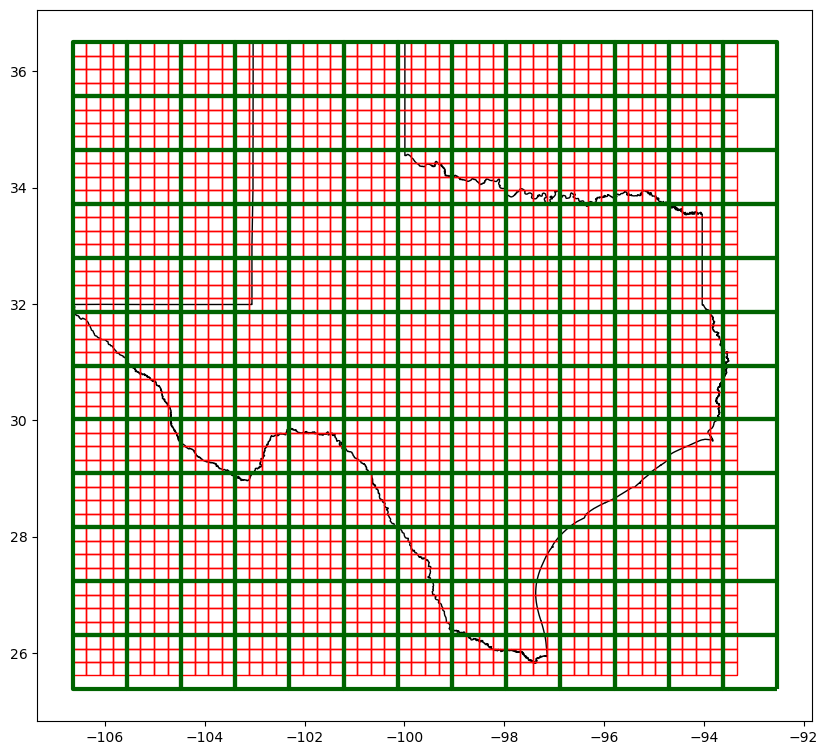

In [21]:
fishnet_creator_example.plot_fishnet()

## Filtering

We can filter the `Fishnet` to one specific region to avoid working on the whole area, simply to increase computational speed.

In [12]:
region = [-95.799944,29.374853,-95.028636,29.795492]

# Filter the fishnet by the larger bounding box
fishnet_creator_example.filter_fishnet_by_bbox(region)
fishnet_creator_example.filtered_fishnet.head(5)

,id,geometry,batch_id
1411,1411,"POLYGON ((-95.78689 29.78485, -95.78689 30.016...",100
1412,1412,"POLYGON ((-95.51541 29.78485, -95.51541 30.016...",101
1413,1413,"POLYGON ((-95.24393 29.78485, -95.24393 30.016...",101
1414,1414,"POLYGON ((-94.97244 29.78485, -94.97244 30.016...",101
1460,1460,"POLYGON ((-95.78689 29.55328, -95.78689 29.784...",100


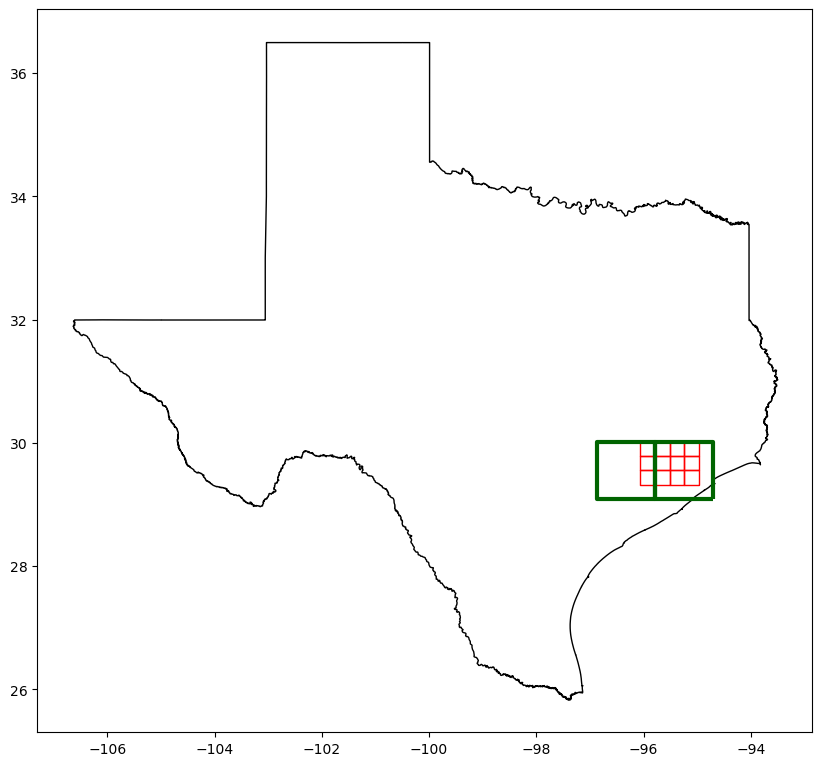

In [14]:
fishnet_creator_example.plot_filtered_fishnet()

## Save and load the fishnet object

In [ ]:
# this specific fishnet was 0.25miles granular and 4miles edge of each batch.
fishnet_creator_example.save('../Gis/Fishnet/fishnet_quarter_mile.pkl') 

# load the object
fishnet_creator_example = Fishnet.load('../Gis/Fishnet/fishnet_quarter_mile.pkl')

# Export Images from the Google Earth Engine

In [4]:
# Load the granular fishnet (0.25miles x 0.25miles)
fishnet_creator = Fishnet.load('../Gis/Fishnet/fishnet_quarter_mile.pkl')

# Filter the fishnet (the one loaded is unfiltered)
region = [-95.799944,29.374853,-95.028636,29.795492]
fishnet_creator.filter_fishnet_by_bbox(region)

In [8]:
image_exporter = ImageExporter(fishnet_creator, filtered=True)

image_exporter.set_date_range(2016)

image_exporter.set_folder('DW_landcover')

image_exporter.export_images()

100%|██████████| 117/117 [00:55<00:00,  2.12it/s]


# Process Images

In [15]:
img_process = ImageProcessor(fishnet_creator, '../Images/export3/', "landcover_batchID", filtered=True)

In [17]:
img_process.process_images()

Processing Images:: 100%|██████████| 117/117 [00:03<00:00, 32.61it/s]


In [20]:
fishnet_creator.filtered_fishnet.head()

,id,geometry,batch_id,ImageCoordinates,MeanPixel
5743150,5743150.0,"POLYGON ((-95.79960 29.79208, -95.79960 29.795...",22469.0,"(567, 524, 615, 564)",162.960938
5743151,5743151.0,"POLYGON ((-95.79536 29.79208, -95.79536 29.795...",22469.0,"(615, 524, 662, 564)",72.023936
5743152,5743152.0,"POLYGON ((-95.79111 29.79208, -95.79111 29.795...",22469.0,"(662, 524, 709, 564)",0.271277
5743153,5743153.0,"POLYGON ((-95.78687 29.79208, -95.78687 29.795...",22469.0,"(709, 524, 757, 564)",24.437500
5743154,5743154.0,"POLYGON ((-95.78263 29.79208, -95.78263 29.795...",22470.0,"(0, 524, 47, 564)",88.300532


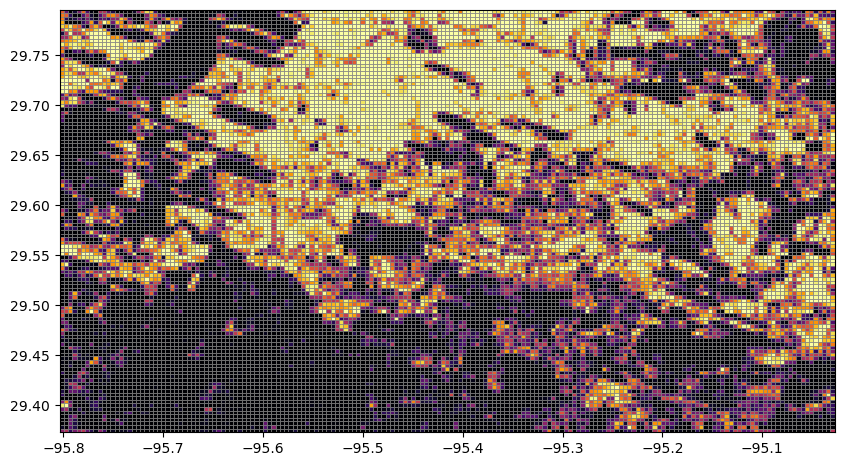

In [26]:
fishnet_creator.plot_heatmap(filtered=True)

In [27]:
fishnet_creator.save('../Gis/Fishnet/fishnet_quarter_mile_2016.pkl')